## Setup

In [1]:
# Packages
import pandas as pd
import torch
from torch.autograd import Variable
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pylab
import math

In [2]:
# Import data
tor_df = pd.read_csv("/home/jeremy/github_tornadoesr/data/raw/tor_train_set.csv")


# Quick inspection
tor_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11959 entries, 0 to 11958
Data columns (total 35 columns):
DAMAGE_PROPERTY       11959 non-null float64
DURATION_SECONDS      11959 non-null float64
BEGIN_LAT             11959 non-null float64
BEGIN_LON             11959 non-null float64
TOR_LENGTH            11959 non-null float64
TOR_WIDTH             11959 non-null float64
YEAR                  11959 non-null float64
MULTI_VORT_IND        11959 non-null int64
OPEN_WATER_PROP       11959 non-null float64
DEV_OPEN_PROP         11959 non-null float64
DEV_LOW_PROP          11959 non-null float64
DEV_MED_PROP          11959 non-null float64
DEV_HIGH_PROP         11959 non-null float64
BARREN_LAND_PROP      11959 non-null float64
DECID_FOREST_PROP     11959 non-null float64
EVERGR_FOREST_PROP    11959 non-null float64
MIXED_FOREST_PROP     11959 non-null float64
SHRUB_SCRUB_PROP      11959 non-null float64
GRASS_LAND_PROP       11959 non-null float64
PASTURE_HAY_PROP      11959 non-null f

In [3]:
# Seperating variables
# The dependent variables
tornado_outcomes = tor_df.iloc[:, [0]]


# Quick inspection
tornado_outcomes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11959 entries, 0 to 11958
Data columns (total 1 columns):
DAMAGE_PROPERTY    11959 non-null float64
dtypes: float64(1)
memory usage: 93.5 KB


In [4]:
# The independent variables
tornado_features = tor_df.iloc[:, 2:34]

tornado_features = tornado_features.drop(["TOR_LENGTH",
                                          "TOR_WIDTH",
                                          "YEAR",
                                          "MULTI_VORT_IND",
                                          "TOR_AREA",
                                          "EXP_INC_AREA",
                                          "DAY_OF_YEAR",
                                          "MONTH"],
                                         axis = 1)


# Quick inspection
tornado_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11959 entries, 0 to 11958
Data columns (total 24 columns):
BEGIN_LAT             11959 non-null float64
BEGIN_LON             11959 non-null float64
OPEN_WATER_PROP       11959 non-null float64
DEV_OPEN_PROP         11959 non-null float64
DEV_LOW_PROP          11959 non-null float64
DEV_MED_PROP          11959 non-null float64
DEV_HIGH_PROP         11959 non-null float64
BARREN_LAND_PROP      11959 non-null float64
DECID_FOREST_PROP     11959 non-null float64
EVERGR_FOREST_PROP    11959 non-null float64
MIXED_FOREST_PROP     11959 non-null float64
SHRUB_SCRUB_PROP      11959 non-null float64
GRASS_LAND_PROP       11959 non-null float64
PASTURE_HAY_PROP      11959 non-null float64
CULT_CROPS_PROP       11959 non-null float64
WOOD_WETLAND_PROP     11959 non-null float64
HERB_WETLAND_PROP     11959 non-null float64
INCOME                11959 non-null float64
MOB_HOME_DENS         11959 non-null float64
POP_DENS              11959 non-null

In [5]:
# Make the dependent variables into a numpy array
outcomes_array = tornado_outcomes.values


# Makes the numpy array into a torch Tensor
outcomes_Tensor = torch.from_numpy(outcomes_array)


# Quick inspection
outcomes_Tensor


 0.1532
 0.6540
 0.0873
   ⋮    
-1.4219
 0.1532
 0.2814
[torch.DoubleTensor of size 11959x1]

In [6]:
# Make the independent variables into a numpy array
features_array = tornado_features.values


# Make the numpy array into a torch Tensor
features_Tensor = torch.from_numpy(features_array)


# Quick inspection
features_Tensor


-1.6434e+00 -4.3226e-01  1.0059e+00  ...   2.4012e-01  9.9841e-01 -8.0985e-01
 2.0633e-01  5.5447e-01  2.5095e-01  ...   6.0023e-01  2.2936e-01  5.1571e-01
-3.3130e-01 -8.9907e-01  6.5406e-01  ...  -5.8070e-01 -1.0991e+00 -1.1142e+00
                ...                   ⋱                   ...                
 1.1642e+00 -1.2164e+00  2.8103e-01  ...  -1.3975e+00 -1.6350e+00  7.8164e-01
-1.2487e+00  6.1127e-01  1.0901e-01  ...   9.1690e-01  4.8438e-01  2.6054e-01
-4.7014e-01 -3.4764e-02  1.6123e+00  ...   5.8210e-01 -4.3274e-01 -3.8082e-01
[torch.DoubleTensor of size 11959x24]

### Convert DoubleTensor to FloatTensor

In [7]:
# Changing dependent variables from a DoubleTensor to a FloatTensor
outcomes_Tensor = outcomes_Tensor.float()


# ...and for the independent variables
features_Tensor = features_Tensor.float()


# Quick check
features_Tensor


-1.6434e+00 -4.3226e-01  1.0059e+00  ...   2.4012e-01  9.9841e-01 -8.0985e-01
 2.0633e-01  5.5447e-01  2.5095e-01  ...   6.0023e-01  2.2936e-01  5.1571e-01
-3.3130e-01 -8.9907e-01  6.5406e-01  ...  -5.8070e-01 -1.0991e+00 -1.1142e+00
                ...                   ⋱                   ...                
 1.1642e+00 -1.2164e+00  2.8103e-01  ...  -1.3975e+00 -1.6350e+00  7.8164e-01
-1.2487e+00  6.1127e-01  1.0901e-01  ...   9.1690e-01  4.8438e-01  2.6054e-01
-4.7014e-01 -3.4764e-02  1.6123e+00  ...   5.8210e-01 -4.3274e-01 -3.8082e-01
[torch.FloatTensor of size 11959x24]

## Round 1: One-Hidden-Layer Neural Network

In [8]:
# Make the torch Tensor into a PyTorch Variable for dependent variables
outcomes_Variable = Variable(outcomes_Tensor)


# ...for independent variables
features_Variable = Variable(features_Tensor,
                             requires_grad = False)

In [9]:
# Make the neural network
model = torch.nn.Sequential(torch.nn.Linear(24, 16),
                            torch.nn.ReLU(),
                            torch.nn.Linear(16, 1))

In [10]:
# Set the loss function
loss_fn = torch.nn.MSELoss(size_average=False)

In [11]:
# To add errors to
errors = []


# Set the learning rate
learning_rate = 1e-2


# Define the model's optimizer
optimizer = torch.optim.Adagrad(model.parameters(), lr = learning_rate)


# Train the neural network
for t in range(10000):
    
    # Get the current predictions
    y_pred = model(features_Variable)
    
    # Compute and append current summed errors
    loss = loss_fn(y_pred, outcomes_Variable)
    errors.append(loss.data[0])
    
    # Zero the gradients before running the backward pass.
    optimizer.zero_grad()
    
    # Backward pass: compute gradient of the loss with respect to all the learnable Variables
    loss.backward()
    
    # Update the weights using Adagrad
    optimizer.step()

In [12]:
# Get the iterations
iterations = list(range(0, 10000))

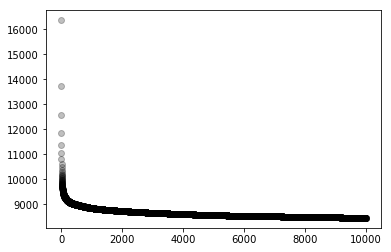

In [13]:
# Plot summed error as a function of iteration
plt.scatter(iterations, errors, c = "black", alpha = 0.25)

In [14]:
# Get rid of the 2nd dimension of 1 from the FloatTensor
y_pred_resized = y_pred.resize(11959)


# Make the FloatTensor into a numpy.array
y_pred_array = y_pred_resized.data.numpy()


# Make the numpy.array into a list
y_pred_list = y_pred_array.tolist()

In [15]:
# Get rid of the 2nd dimension of 1 from the FloatTensor
outcomes_Variable_resized = outcomes_Variable.resize(11959)


# Make the FloatTensor into a numpy.array
outcomes_array = outcomes_Variable_resized.data.numpy()


# Make the numpy.array into a list
outcomes_list = outcomes_array.tolist()

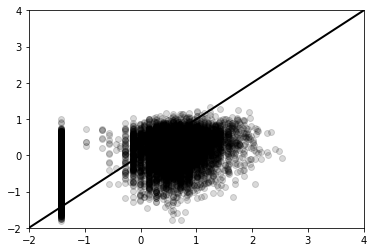

In [16]:
# Plot predictions versus training set outcomes
plt.scatter(outcomes_list, y_pred_list, c = "black", alpha = 0.15)

axes = plt.gca()

axes.set_xlim([-2, 4])

axes.set_ylim([-2, 4])

plt.plot([-2, 4], [-2, 4], 'k-', lw=2)

### Round 1.1: Validation Set Performance

In [17]:
# Import data
valid_df = pd.read_csv("/home/jeremy/github_tornadoesr/data/raw/tor_cv_set.csv")


# Validation set outcomes
valid_outcomes = valid_df.iloc[:, [0]]


# Make the validation outcomes into a numpy array
valid_outcomes_array = valid_outcomes.values


# Makes the numpy array into a torch Tensor
valid_outcomes_Tensor = torch.from_numpy(valid_outcomes_array)


# Changing validation outcomes from a DoubleTensor to a FloatTensor
valid_outcomes_Tensor = valid_outcomes_Tensor.float()


# Make the Tensor into a Pytorch Variable
valid_outcomes_Variable = Variable(valid_outcomes_Tensor)


# Quick check
valid_outcomes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3987 entries, 0 to 3986
Data columns (total 1 columns):
DAMAGE_PROPERTY    3987 non-null float64
dtypes: float64(1)
memory usage: 31.2 KB


In [18]:
# Validation set predictors
valid_predictors = valid_df.iloc[:, 2:34]

valid_predictors = valid_predictors.drop(["TOR_LENGTH",
                                          "TOR_WIDTH",
                                          "YEAR",
                                          "MULTI_VORT_IND",
                                          "TOR_AREA",
                                          "EXP_INC_AREA",
                                          "DAY_OF_YEAR",
                                          "MONTH"],
                                         axis = 1)


# Make the validation predictors into a numpy array
valid_predictors_array = valid_predictors.values


# Makes the numpy array into a torch Tensor
valid_predictors_Tensor = torch.from_numpy(valid_predictors_array)


# Changing validation predictors from a DoubleTensor to a FloatTensor
valid_predictors_Tensor = valid_predictors_Tensor.float()


# Make the Tensor into a Pytorch Variable
valid_predictors_Variable = Variable(valid_predictors_Tensor)


# Quick check
valid_predictors.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3987 entries, 0 to 3986
Data columns (total 24 columns):
BEGIN_LAT             3987 non-null float64
BEGIN_LON             3987 non-null float64
OPEN_WATER_PROP       3987 non-null float64
DEV_OPEN_PROP         3987 non-null float64
DEV_LOW_PROP          3987 non-null float64
DEV_MED_PROP          3987 non-null float64
DEV_HIGH_PROP         3987 non-null float64
BARREN_LAND_PROP      3987 non-null float64
DECID_FOREST_PROP     3987 non-null float64
EVERGR_FOREST_PROP    3987 non-null float64
MIXED_FOREST_PROP     3987 non-null float64
SHRUB_SCRUB_PROP      3987 non-null float64
GRASS_LAND_PROP       3987 non-null float64
PASTURE_HAY_PROP      3987 non-null float64
CULT_CROPS_PROP       3987 non-null float64
WOOD_WETLAND_PROP     3987 non-null float64
HERB_WETLAND_PROP     3987 non-null float64
INCOME                3987 non-null float64
MOB_HOME_DENS         3987 non-null float64
POP_DENS              3987 non-null float64
TOT_DEV_INT  

In [19]:
# Get the validation set predictions
y_valid_pred = model(valid_predictors_Variable)


# Print the loss
loss_fn(y_valid_pred,
        valid_outcomes_Variable)

Variable containing:
 3118.4626
[torch.FloatTensor of size 1]

In [20]:
# Get rid of the 2nd dimension of 1 from the FloatTensor
y_valid_pred_resized = y_valid_pred.resize(3987)


# Make the FloatTensor into a numpy.array
y_valid_pred_array = y_valid_pred_resized.data.numpy()


# Convert back to log scale
y_valid_pred_array = y_valid_pred_array*5.407597 + 7.688844


# Make the numpy.array into a list
y_valid_pred_list = y_valid_pred_array.tolist()

In [21]:
# Get rid of the 2nd dimension of 1 from the FloatTensor
valid_outcomes_Variable_resized = valid_outcomes_Variable.resize(3987)


# Make the FloatTensor into a numpy.array
valid_outcomes_array = valid_outcomes_Variable_resized.data.numpy()


# Convert back to log scale
valid_outcomes_array = valid_outcomes_array*5.407597 + 7.688844


# Make the numpy.array into a list
valid_outcomes_list = valid_outcomes_array.tolist()

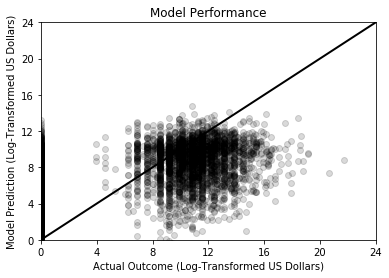

In [22]:
# Plot new predictions versus new data outcomes
plt.scatter(valid_outcomes_list, y_valid_pred_list, c = "black", alpha = 0.15)

axes = plt.gca()

axes.set_xlim([0, 24])

axes.set_ylim([0, 24])

axes.set_xticks([0, 4, 8, 12, 16, 20, 24])

axes.set_yticks([0, 4, 8, 12, 16, 20, 24])

plt.plot([0, 24], [0, 24], 'k-', lw = 2)

axes.set_xlabel("Actual Outcome (Log-Transformed US Dollars)")

axes.set_ylabel("Model Prediction (Log-Transformed US Dollars)")

axes.set_title("Model Performance")

In [23]:
model[(0)].weight

Parameter containing:

Columns 0 to 9 
 0.0756  0.0479 -0.1130 -0.1785 -0.0970  0.1842 -0.0718 -0.1482 -0.3158 -0.0581
-0.0640 -0.1339  0.1735 -0.0484  0.2129 -0.3030  0.0813  0.0183 -0.2020  0.0197
 0.2741  0.2583 -0.0217  0.2355 -0.0068  0.4170 -0.1852 -0.4061  0.0554 -0.0940
 0.2582 -0.1903 -0.0239  0.0363  0.5055 -0.0706 -0.2226  0.0577  0.3411 -0.5520
 0.1803 -0.0549  0.1448 -0.0178 -0.1350 -0.2643 -0.1053  0.3492 -0.0916  0.1319
 0.1262 -0.3603 -0.0101  0.1728 -0.0373 -0.0047  0.0880 -0.1926  0.3133  0.1519
-0.1302  0.0816 -0.1288 -0.3241  0.0365 -0.0793  0.2880  0.0160 -0.3625  0.2872
-0.0486 -0.2245 -0.0197 -0.1015  0.3179 -0.1245 -0.3259  0.2077 -0.2953 -0.2876
 0.4014  0.2072 -0.1716  0.3132 -0.1094  0.2750 -0.2755  0.0064  0.2398 -0.1701
-0.0864  0.0254  0.1675  0.4286 -0.0700 -0.0930  0.1191  0.1941  0.1912  0.0868
-0.2043  0.0646 -0.1020  0.0999  0.2649 -0.0774  0.3468 -0.0068  0.0859  0.5415
 0.1948  0.2136 -0.0371  0.0317  0.3294  0.2905 -0.4097 -0.3308  0.1723 -0.1352
 

In [24]:
model[(2)].weight

Parameter containing:

Columns 0 to 9 
 0.2922  0.3764 -0.5839 -0.4475 -0.3491 -0.5017  0.3248  0.3486  0.3883  0.3525

Columns 10 to 15 
-0.2546  0.4418 -0.3830  0.3189 -0.4289  0.4148
[torch.FloatTensor of size 1x16]

## Round 2: Two-Hidden-Layer Neural Network

In [25]:
# Make the torch Tensor into a PyTorch Variable for dependent variables
outcomes_Variable = Variable(outcomes_Tensor)


# ...for independent variables
features_Variable = Variable(features_Tensor,
                             requires_grad = False)

In [26]:
# Make the neural network
model = torch.nn.Sequential(torch.nn.Linear(24, 16),
                            torch.nn.ReLU(),
                            torch.nn.Linear(16, 11),
                            torch.nn.ReLU(),
                            torch.nn.Linear(11, 1))

In [27]:
# To add errors to
errors = []


# Set the learning rate
learning_rate = 1e-2


# Define the model's optimizer
optimizer = torch.optim.Adagrad(model.parameters(), lr = learning_rate)


# Train the neural network
for t in range(10000):
    
    # Get the current predictions
    y_pred = model(features_Variable)
    
    # Compute and append current summed errors
    loss = loss_fn(y_pred, outcomes_Variable)
    errors.append(loss.data[0])
    
    # Zero the gradients before running the backward pass.
    optimizer.zero_grad()
    
    # Backward pass: compute gradient of the loss with respect to all the learnable Variables
    loss.backward()
    
    # Update the weights using Adagrad
    optimizer.step()

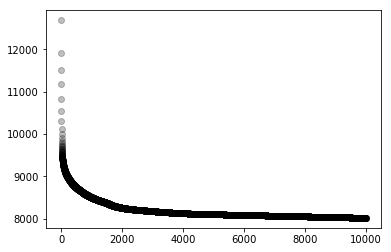

In [28]:
# Plot summed error as a function of iteration
plt.scatter(iterations, errors, c = "black", alpha = 0.25)

In [29]:
# Get rid of the 2nd dimension of 1 from the FloatTensor
y_pred_resized = y_pred.resize(11959)


# Make the FloatTensor into a numpy.array
y_pred_array = y_pred_resized.data.numpy()


# Make the numpy.array into a list
y_pred_list = y_pred_array.tolist()

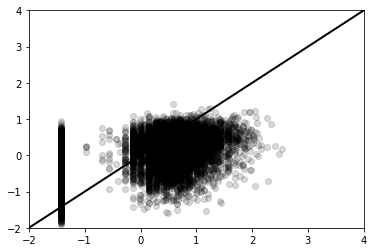

In [30]:
# Plot predictions versus training set outcomes
plt.scatter(outcomes_list, y_pred_list, c = "black", alpha = 0.15)

axes = plt.gca()

axes.set_xlim([-2, 4])

axes.set_ylim([-2, 4])

plt.plot([-2, 4], [-2, 4], 'k-', lw=2)

### Round 2.1: Validation Set Performance

In [31]:
# Get the validation set predictions
y_valid_pred = model(valid_predictors_Variable)


# Print the loss
loss_fn(y_valid_pred,
        valid_outcomes_Variable)

Variable containing:
 3129.0405
[torch.FloatTensor of size 1]

In [32]:
# Get rid of the 2nd dimension of 1 from the FloatTensor
y_valid_pred_resized = y_valid_pred.resize(3987)


# Make the FloatTensor into a numpy.array
y_valid_pred_array = y_valid_pred_resized.data.numpy()


# Convert back to log scale
y_valid_pred_array = y_valid_pred_array*5.407597 + 7.688844


# Make the numpy.array into a list
y_valid_pred_list = y_valid_pred_array.tolist()

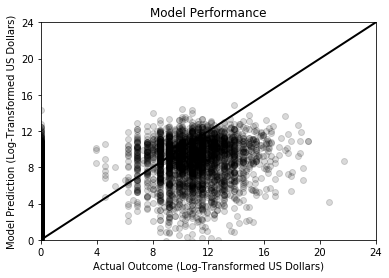

In [33]:
# Plot new predictions versus new data outcomes
plt.scatter(valid_outcomes_list, y_valid_pred_list, c = "black", alpha = 0.15)

axes = plt.gca()

axes.set_xlim([0, 24])

axes.set_ylim([0, 24])

axes.set_xticks([0, 4, 8, 12, 16, 20, 24])

axes.set_yticks([0, 4, 8, 12, 16, 20, 24])

plt.plot([0, 24], [0, 24], 'k-', lw = 2)

axes.set_xlabel("Actual Outcome (Log-Transformed US Dollars)")

axes.set_ylabel("Model Prediction (Log-Transformed US Dollars)")

axes.set_title("Model Performance")

In [34]:
model[(0)].weight

Parameter containing:

Columns 0 to 9 
-0.3751 -0.2020 -0.1667 -0.0588 -0.1550  0.0573 -0.0407 -0.0310 -0.4399 -0.1059
-0.1605 -0.4021  0.1894  0.1266  0.0608 -0.1317  0.0620 -0.0950 -0.4211  0.1804
-0.1539 -0.1817  0.1456 -0.3762  0.1965  0.0164 -0.3340  0.0922 -0.1369  0.1725
 0.2804 -0.3374 -0.0045  0.1176  0.0652 -0.0206 -0.1860 -0.0120  0.1820 -0.1099
-0.1525  0.2248  0.1528 -0.4317 -0.1019 -0.1974  0.2081 -0.2915  0.2215  0.5623
-0.3961  0.1742 -0.1340  0.1666  0.1191  0.3863  0.2219 -0.0352  0.0933  0.2861
 0.2058  0.2389  0.1513  0.4689 -0.2263 -0.0454  0.2871 -0.2614  0.0699  0.0236
 0.1221  0.1478 -0.0400 -0.2447  0.5060  0.1911 -0.5220  0.2076 -0.1098 -0.3651
 0.1670 -0.1811  0.1553  0.0910  0.1538 -0.0707 -0.2057 -0.0531  0.0100 -0.0577
-0.2382 -0.1979 -0.2403  0.1036 -0.0257  0.1289 -0.1550  0.0749 -0.4014 -0.2592
 0.0202  0.1350 -0.0888 -0.3904 -0.3212  0.5703 -0.0688 -0.2278 -0.2670 -0.2396
-0.0624 -0.0250 -0.0393 -0.1365 -0.0329  0.1486 -0.3794  0.0219  0.0553 -0.3275
-

In [35]:
model[(2)].weight

Parameter containing:

Columns 0 to 9 
-0.0284  0.0741  0.0105  0.2419 -0.0893  0.1022  0.1948  0.2588 -0.5418 -0.3239
 0.3902 -0.4581  0.1537  0.2109 -1.0539  0.0272 -0.0853  0.1727 -0.2319 -0.2903
 0.1091 -0.0726  0.5265 -0.0134  0.4014  0.4979  0.1783  0.3789  0.2869  0.0719
 0.3627 -0.0483  0.2243  0.5347  0.1011 -0.1456 -0.0098 -0.2024 -0.2929 -0.6952
-0.4635 -0.3846 -0.0567 -0.2263 -0.0515  0.4888  0.1016 -0.5596  0.0547  0.2477
 0.4149  0.3584  0.5083  0.1726 -0.7435  0.6951  0.1918  0.1940 -0.1261 -0.3732
-0.2020 -0.4392 -0.5937 -0.2324  0.1802  0.1692  0.1663  0.4486  0.5464  0.1274
 0.0942 -0.2171  0.1898  0.0925 -0.5713  0.3495  0.4015  0.2897 -0.0824  0.2530
 0.0331  0.2990  0.4375 -0.8625  0.4344 -0.3461 -0.9264  0.4378 -0.0029  0.0667
-0.4682  0.0288  0.1557 -0.2255  0.4020 -0.1089 -0.3597 -0.3577  0.1012  0.2133
 0.0902 -0.1190  0.2564 -0.1162 -0.2783 -0.1635 -0.0128  0.1750 -0.2303  0.0806

Columns 10 to 15 
-0.0387  0.2003 -0.1970 -0.1544 -0.5811 -0.0624
 0.4808  0.411

In [36]:
model[(4)].weight

Parameter containing:

Columns 0 to 9 
-0.7069  0.8786 -0.4096 -0.6506  0.6309 -0.5083  0.8721 -0.4582  0.7914 -0.6826

Columns 10 to 10 
-0.6442
[torch.FloatTensor of size 1x11]

## Round 3: Three-Hidden-Layer Neural Network

In [37]:
# Make the torch Tensor into a PyTorch Variable for dependent variables
outcomes_Variable = Variable(outcomes_Tensor)


# ...for independent variables
features_Variable = Variable(features_Tensor,
                             requires_grad = False)

In [38]:
# Make the neural network
model = torch.nn.Sequential(torch.nn.Linear(24, 16),
                            torch.nn.ReLU(),
                            torch.nn.Linear(16, 11),
                            torch.nn.ReLU(),
                            torch.nn.Linear(11, 7),
                            torch.nn.ReLU(),
                            torch.nn.Linear(7, 1))

In [39]:
# To add errors to
errors = []


# Set the learning rate
learning_rate = 1e-2


# Define the model's optimizer
optimizer = torch.optim.Adagrad(model.parameters(), lr = learning_rate)


# Train the neural network
for t in range(10000):
    
    # Get the current predictions
    y_pred = model(features_Variable)
    
    # Compute and append current summed errors
    loss = loss_fn(y_pred, outcomes_Variable)
    errors.append(loss.data[0])
    
    # Zero the gradients before running the backward pass.
    optimizer.zero_grad()
    
    # Backward pass: compute gradient of the loss with respect to all the learnable Variables
    loss.backward()
    
    # Update the weights using Adagrad
    optimizer.step()

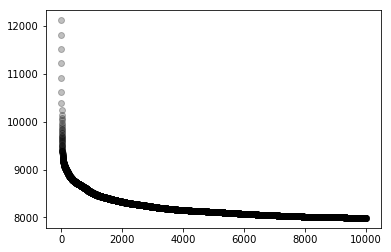

In [40]:
# Plot summed error as a function of iteration
plt.scatter(iterations, errors, c = "black", alpha = 0.25)

In [41]:
# Get rid of the 2nd dimension of 1 from the FloatTensor
y_pred_resized = y_pred.resize(11959)


# Make the FloatTensor into a numpy.array
y_pred_array = y_pred_resized.data.numpy()


# Make the numpy.array into a list
y_pred_list = y_pred_array.tolist()

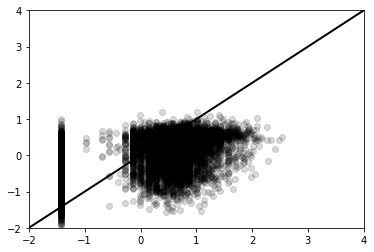

In [42]:
# Plot predictions versus training set outcomes
plt.scatter(outcomes_list, y_pred_list, c = "black", alpha = 0.15)

axes = plt.gca()

axes.set_xlim([-2, 4])

axes.set_ylim([-2, 4])

plt.plot([-2, 4], [-2, 4], 'k-', lw=2)

### Round 3.1: Validation Set Performance

In [43]:
# Get the validation set predictions
y_valid_pred = model(valid_predictors_Variable)


# Print the loss
loss_fn(y_valid_pred,
        valid_outcomes_Variable)

Variable containing:
 3225.7869
[torch.FloatTensor of size 1]

In [44]:
# Get rid of the 2nd dimension of 1 from the FloatTensor
y_valid_pred_resized = y_valid_pred.resize(3987)


# Make the FloatTensor into a numpy.array
y_valid_pred_array = y_valid_pred_resized.data.numpy()


# Convert back to log scale
y_valid_pred_array = y_valid_pred_array*5.407597 + 7.688844


# Make the numpy.array into a list
y_valid_pred_list = y_valid_pred_array.tolist()

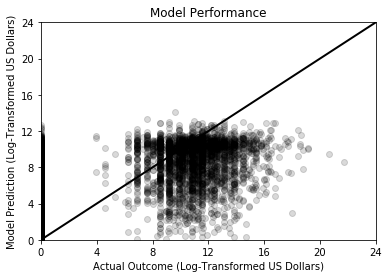

In [45]:
# Plot new predictions versus new data outcomes
plt.scatter(valid_outcomes_list, y_valid_pred_list, c = "black", alpha = 0.15)

axes = plt.gca()

axes.set_xlim([0, 24])

axes.set_ylim([0, 24])

axes.set_xticks([0, 4, 8, 12, 16, 20, 24])

axes.set_yticks([0, 4, 8, 12, 16, 20, 24])

plt.plot([0, 24], [0, 24], 'k-', lw = 2)

axes.set_xlabel("Actual Outcome (Log-Transformed US Dollars)")

axes.set_ylabel("Model Prediction (Log-Transformed US Dollars)")

axes.set_title("Model Performance")

In [46]:
model[(0)].weight

Parameter containing:

Columns 0 to 9 
-0.1613  0.3420  0.1833 -0.3474  0.0772  0.1338  0.4950  0.1159 -0.1080  0.3948
 0.2043  0.1416  0.1984 -0.0697  0.4746  0.1583  0.3055  0.0945  0.0492  0.0090
 0.1560 -0.1288  0.0502 -0.1139 -0.1688  0.0038 -0.0385 -0.1651  0.0519  0.0161
 0.1450 -0.2526 -0.1958 -0.4342  0.0663 -0.1453 -0.0898  0.0337  0.4577 -0.3483
-0.0574  0.1055 -0.0552  0.0431 -0.4890 -0.1286 -0.1150 -0.0229 -0.0461 -0.3083
 0.1813 -0.0990 -0.0938  0.0748  0.2988 -0.1407 -0.0350 -0.0196 -0.0088  0.0510
-0.1571 -0.5450 -0.1706  0.0626  0.2874 -0.3288  0.0656 -0.2382 -0.3060 -0.1823
 0.2262  0.4259 -0.0997  0.1989 -0.1950  0.2653  0.2128  0.0077  0.1074  0.4201
 0.4766  0.0773 -0.0889  0.3318 -0.1266  0.1154 -0.0943 -0.0454 -0.1866  0.0904
 0.1410 -0.2554  0.1762  0.0824  0.1374 -0.1726  0.0350 -0.3542  0.2201 -0.0036
 0.0201 -0.0824  0.0804  0.1797 -0.0094  0.0272 -0.1025  0.2867 -0.2631  0.0737
 0.1419 -0.2046  0.0216  0.1247 -0.0142 -0.5211 -0.1725 -0.0265  0.2157 -0.0836
 

In [47]:
model[(2)].weight

Parameter containing:

Columns 0 to 9 
-0.3000 -0.0799  0.1223  0.0106  0.4182  0.3941  0.0566  0.0049 -0.0255  0.0600
-0.1088  0.3815  0.2481 -0.4171 -0.2422 -0.0655  0.1302 -0.2418  0.3573 -0.0292
-0.6644  0.3956  0.0047 -0.0500 -0.0698 -0.6910 -0.1113 -0.9372  0.3058 -0.2210
-0.2509 -0.0009  0.2331  0.0567  0.0929 -0.0396 -0.1276 -0.5240  0.2188 -0.0100
 0.1888 -0.2220 -0.0445  0.4447  0.0195  0.5179  0.3712  0.0404 -0.0916 -0.0954
 0.3117  0.2753  0.3486  0.3841  0.0305 -0.2508  0.1624 -0.1357  0.3482  0.3966
 0.4073 -0.3695 -1.8670 -1.2914 -0.6564  0.1117 -1.4725 -0.3616  0.0882 -0.0708
 0.0824  0.7202  0.0176 -0.0412  0.0558  0.0967  0.1152 -0.1349 -0.0037 -0.0376
 0.2717  0.1427  0.0387 -0.3202 -0.1774 -0.6207  0.0333  0.1077  0.2009  0.5316
 0.2613  0.1865 -0.0090 -0.0324  0.0400  0.0783  0.3344  0.0338  0.1808 -0.2355
-0.3983  0.3284  0.1710  0.1040  0.0427 -0.6634  0.1038  0.1894 -0.1355  0.4806

Columns 10 to 15 
 0.3795 -0.1274  0.0168 -0.0087 -0.0378 -0.3158
 0.0317  0.242

In [48]:
model[(4)].weight

Parameter containing:

Columns 0 to 9 
 0.3678  0.5477  0.6000  0.1560  0.5161  0.0801  1.2191 -0.1088  0.4862 -0.1815
-0.0844  0.6614  0.6904  0.2267  0.1204  0.2461  1.2927 -0.3672  0.3690 -0.2354
-0.1524  0.9058  0.1209  0.0644  0.0277 -1.3580 -0.1412 -0.0444 -0.0155  0.2290
-0.2387 -0.1937  0.2909 -0.0263 -0.0020  0.0178  0.0169 -0.2087 -0.0329  0.1267
 0.1537  0.4371 -0.0363 -0.2003 -0.1245  0.0425 -0.6731  0.4949 -0.8842  0.2424
-0.2979 -0.2606 -0.2185 -0.0578  0.0103 -0.2955 -0.0233 -0.2761  0.0875 -0.2113
 0.4930  0.4924  0.5412  0.2558  0.6034 -0.3314  1.2998 -0.1436  0.8452 -0.0230

Columns 10 to 10 
-0.0381
 0.3520
 0.3303
-0.1446
-0.1776
 0.0542
 0.1202
[torch.FloatTensor of size 7x11]

In [49]:
model[(6)].weight

Parameter containing:
-0.5634 -0.6083 -1.8024 -0.1357  0.4106 -0.2266 -0.6216
[torch.FloatTensor of size 1x7]

## Round 4: Four-Hidden-Layer Neural Network

In [50]:
# Make the torch Tensor into a PyTorch Variable for dependent variables
outcomes_Variable = Variable(outcomes_Tensor)


# ...for independent variables
features_Variable = Variable(features_Tensor,
                             requires_grad = False)

In [51]:
# Make the neural network
model = torch.nn.Sequential(torch.nn.Linear(24, 16),
                            torch.nn.ReLU(),
                            torch.nn.Linear(16, 11),
                            torch.nn.ReLU(),
                            torch.nn.Linear(11, 7),
                            torch.nn.ReLU(),
                            torch.nn.Linear(7, 5),
                            torch.nn.ReLU(),
                            torch.nn.Linear(5, 1))

In [52]:
# To add errors to
errors = []


# Set the learning rate
learning_rate = 1e-2


# Define the model's optimizer
optimizer = torch.optim.Adagrad(model.parameters(), lr = learning_rate)


# Train the neural network
for t in range(10000):
    
    # Get the current predictions
    y_pred = model(features_Variable)
    
    # Compute and append current summed errors
    loss = loss_fn(y_pred, outcomes_Variable)
    errors.append(loss.data[0])
    
    # Zero the gradients before running the backward pass.
    optimizer.zero_grad()
    
    # Backward pass: compute gradient of the loss with respect to all the learnable Variables
    loss.backward()
    
    # Update the weights using Adagrad
    optimizer.step()

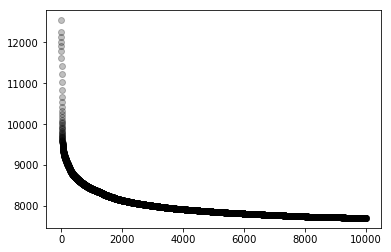

In [53]:
# Plot summed error as a function of iteration
plt.scatter(iterations, errors, c = "black", alpha = 0.25)

In [54]:
# Get rid of the 2nd dimension of 1 from the FloatTensor
y_pred_resized = y_pred.resize(11959)


# Make the FloatTensor into a numpy.array
y_pred_array = y_pred_resized.data.numpy()


# Make the numpy.array into a list
y_pred_list = y_pred_array.tolist()

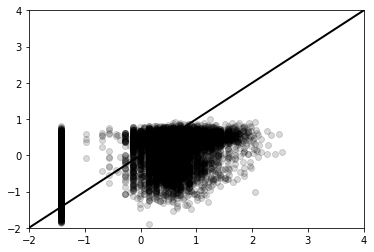

In [55]:
# Plot predictions versus training set outcomes
plt.scatter(outcomes_list, y_pred_list, c = "black", alpha = 0.15)

axes = plt.gca()

axes.set_xlim([-2, 4])

axes.set_ylim([-2, 4])

plt.plot([-2, 4], [-2, 4], 'k-', lw=2)

### Round 4.1: Validation Set Performance

In [56]:
# Get the validation set predictions
y_valid_pred = model(valid_predictors_Variable)


# Print the loss
loss_fn(y_valid_pred,
        valid_outcomes_Variable)

Variable containing:
 3232.1091
[torch.FloatTensor of size 1]

In [57]:
# Get rid of the 2nd dimension of 1 from the FloatTensor
y_valid_pred_resized = y_valid_pred.resize(3987)


# Make the FloatTensor into a numpy.array
y_valid_pred_array = y_valid_pred_resized.data.numpy()


# Convert back to log scale
y_valid_pred_array = y_valid_pred_array*5.407597 + 7.688844


# Make the numpy.array into a list
y_valid_pred_list = y_valid_pred_array.tolist()

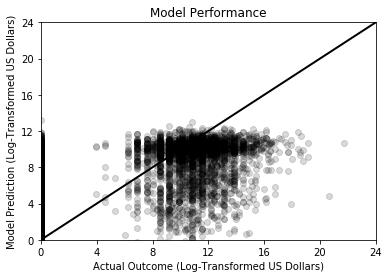

In [58]:
# Plot new predictions versus new data outcomes
plt.scatter(valid_outcomes_list, y_valid_pred_list, c = "black", alpha = 0.15)

axes = plt.gca()

axes.set_xlim([0, 24])

axes.set_ylim([0, 24])

axes.set_xticks([0, 4, 8, 12, 16, 20, 24])

axes.set_yticks([0, 4, 8, 12, 16, 20, 24])

plt.plot([0, 24], [0, 24], 'k-', lw = 2)

axes.set_xlabel("Actual Outcome (Log-Transformed US Dollars)")

axes.set_ylabel("Model Prediction (Log-Transformed US Dollars)")

axes.set_title("Model Performance")

In [59]:
model[(0)].weight

Parameter containing:

Columns 0 to 9 
-0.2368  0.0142  0.0021 -0.0897  0.1348 -0.1632 -0.0547  0.2476 -0.1304  0.3240
-0.0928  0.2980  0.2208  0.0073 -0.4255  0.0140  0.2288  0.0380 -0.1033  0.2237
 0.0013  0.1062 -0.0411  0.1606 -0.2037 -0.0783  0.0505  0.0140  0.3806  0.2011
 0.0201 -0.0385  0.0786 -0.2748 -0.1684 -0.1296 -0.1160  0.1698 -0.0621  0.1278
 0.1879  0.0928  0.0056  0.1549 -0.0639 -0.1179 -0.2973 -0.1152  0.1102 -0.2526
 0.1033 -0.0633 -0.0423  0.0204 -0.0932 -0.4512  0.0949 -0.1251  0.3632  0.1946
-0.0579  0.1291  0.3871 -0.1489 -0.1137 -0.3022  0.2076 -0.1657 -0.2110 -0.1733
-0.2823 -0.2975 -0.2759 -0.2429 -0.2574 -0.1813 -0.0560  0.4047 -0.0699 -0.0320
 0.0130 -0.3143  0.0951  0.4534 -0.0619  0.1103 -0.1507 -0.1155  0.4915  0.1417
 0.1572 -0.3748 -0.0670  0.1388 -0.2458  0.2912 -0.0203 -0.1180  0.3622  0.3391
-0.2347  0.3980 -0.2139 -0.2489  0.3888 -0.5789  0.2084  0.3415 -0.1971 -0.4068
 0.1036 -0.3066  0.1611  0.0746 -0.3501  0.0878  0.3192 -0.2129 -0.4194 -0.1637
-

In [60]:
model[(2)].weight

Parameter containing:

Columns 0 to 9 
-0.4001 -0.1711  0.0738  0.2484  0.0678  0.3881  0.0335 -0.0003 -0.0076  0.0638
 0.0801 -0.5007 -0.9710 -0.4702  0.4023 -0.1375  0.0902  0.4035 -0.1990  0.3910
 0.1455  0.0434  0.1492 -0.0377 -0.3760  0.1917  0.1988 -0.0122  0.1388  0.0725
-0.0555  0.0345  0.1618 -0.2111  0.2087  0.3443  0.4033 -0.2137 -0.2295 -0.1057
-0.1348  0.1982  0.1070 -0.1350 -0.0029  0.0401  0.3304  0.1871  0.0017 -0.2831
-0.4600 -0.0516 -0.4315  0.1954 -0.1844  0.4356 -1.9083  0.1091  0.3032  0.3183
-0.2759  0.1593 -0.3046 -0.2086  0.1512 -0.0669  0.0772  0.0722 -0.0932 -0.0429
 0.4786 -0.3961 -0.1183  0.0779  0.1013  0.3008  0.0691 -0.1577 -1.1337 -1.3271
-0.3246  0.3266  0.2032  0.2307  0.1492 -0.4025  0.4081 -0.5200 -0.2728  0.7217
 0.3098 -1.1893 -0.4063 -0.1809  0.4273  0.0253  0.2133 -0.4979 -0.0737  0.0826
-0.7879  0.4603 -0.0412  0.0190  0.3380 -0.2835 -0.1316 -0.0118  0.3532 -0.2076

Columns 10 to 15 
-0.1064  0.2221  0.2047  0.4699 -0.2340  0.3228
-0.2410  0.241

In [61]:
model[(4)].weight

Parameter containing:

Columns 0 to 9 
-0.6786 -0.0050  0.5764  0.1397 -1.4746  0.2576  0.0361  0.0428  0.3037  0.2973
-0.1234 -0.0314 -0.0956 -0.0064 -0.2759 -0.2724 -0.1937  0.1592 -0.1416  0.0517
 0.5417 -0.8667  0.4808 -0.0467  0.0740 -0.3405 -0.4013 -0.6752  0.2289  0.1563
 0.1700  0.2612  0.0987  0.3805  0.3744  0.7757  0.2420  0.3033 -0.8318  0.1742
 0.4775 -0.4695  0.2625  0.3769 -0.2245 -0.7575  0.3123 -0.2648 -0.6354 -0.1167
-0.1429  0.2023 -0.4897  0.3722  0.2167  0.8999  0.3798  0.6563 -0.7286  0.3320
 0.1710  0.1061 -0.5498  0.4557  0.1275  0.5018  0.2104  0.5888 -0.7788  0.3307

Columns 10 to 10 
 0.3281
-0.1139
-0.1151
-0.4307
-0.0113
-0.6497
-0.7016
[torch.FloatTensor of size 7x11]

In [62]:
model[(6)].weight

Parameter containing:
 0.8056 -0.2590 -0.8230  0.5792  0.0378  0.6607  0.5978
-0.2778 -0.2457  0.2649 -0.0838  0.3175 -0.5260 -0.2960
-0.0615  0.0017 -0.1152 -0.0649  0.0900 -0.3661 -0.0908
 0.3673  0.1718 -0.3943 -0.2627 -0.1478 -0.2968 -0.0462
 1.2512  0.1498 -1.3500  0.6144  0.0864 -0.5164 -0.2009
[torch.FloatTensor of size 5x7]

In [63]:
model[(8)].weight

Parameter containing:
-0.8329  0.9017 -0.3725 -0.1171 -2.6770
[torch.FloatTensor of size 1x5]

## Round 5: Five-Hidden-Layer Neural Network

In [64]:
# Make the torch Tensor into a PyTorch Variable for dependent variables
outcomes_Variable = Variable(outcomes_Tensor)


# ...for independent variables
features_Variable = Variable(features_Tensor,
                             requires_grad = False)

In [65]:
# Make the neural network
model = torch.nn.Sequential(torch.nn.Linear(24, 16),
                            torch.nn.ReLU(),
                            torch.nn.Linear(16, 11),
                            torch.nn.ReLU(),
                            torch.nn.Linear(11, 7),
                            torch.nn.ReLU(),
                            torch.nn.Linear(7, 5),
                            torch.nn.ReLU(),
                            torch.nn.Linear(5, 3),
                            torch.nn.ReLU(),
                            torch.nn.Linear(3, 1))

In [66]:
# To add errors to
errors = []


# Set the learning rate
learning_rate = 1e-2


# Define the model's optimizer
optimizer = torch.optim.Adagrad(model.parameters(), lr = learning_rate)


# Train the neural network
for t in range(10000):
    
    # Get the current predictions
    y_pred = model(features_Variable)
    
    # Compute and append current summed errors
    loss = loss_fn(y_pred, outcomes_Variable)
    errors.append(loss.data[0])
    
    # Zero the gradients before running the backward pass.
    optimizer.zero_grad()
    
    # Backward pass: compute gradient of the loss with respect to all the learnable Variables
    loss.backward()
    
    # Update the weights using Adagrad
    optimizer.step()

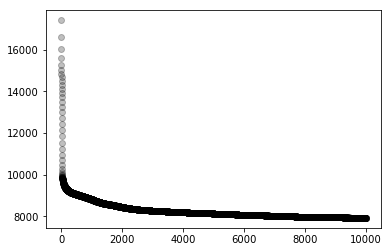

In [67]:
# Plot summed error as a function of iteration
plt.scatter(iterations, errors, c = "black", alpha = 0.25)

In [68]:
# Get rid of the 2nd dimension of 1 from the FloatTensor
y_pred_resized = y_pred.resize(11959)


# Make the FloatTensor into a numpy.array
y_pred_array = y_pred_resized.data.numpy()


# Make the numpy.array into a list
y_pred_list = y_pred_array.tolist()

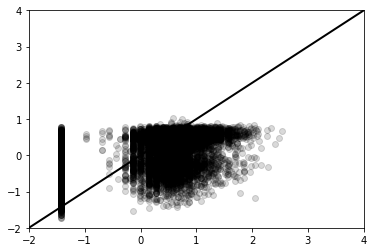

In [69]:
# Plot predictions versus training set outcomes
plt.scatter(outcomes_list, y_pred_list, c = "black", alpha = 0.15)

axes = plt.gca()

axes.set_xlim([-2, 4])

axes.set_ylim([-2, 4])

plt.plot([-2, 4], [-2, 4], 'k-', lw=2)

### Round 5.1: Validation Set Performance

In [70]:
# Get the validation set predictions
y_valid_pred = model(valid_predictors_Variable)


# Print the loss
loss_fn(y_valid_pred,
        valid_outcomes_Variable)

Variable containing:
 3218.6096
[torch.FloatTensor of size 1]

In [71]:
# Get rid of the 2nd dimension of 1 from the FloatTensor
y_valid_pred_resized = y_valid_pred.resize(3987)


# Make the FloatTensor into a numpy.array
y_valid_pred_array = y_valid_pred_resized.data.numpy()


# Convert back to log scale
y_valid_pred_array = y_valid_pred_array*5.407597 + 7.688844


# Make the numpy.array into a list
y_valid_pred_list = y_valid_pred_array.tolist()

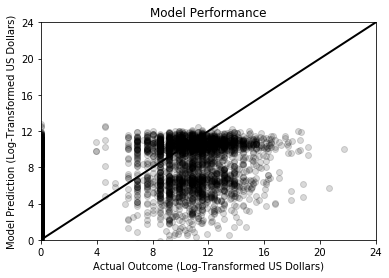

In [72]:
# Plot new predictions versus new data outcomes
plt.scatter(valid_outcomes_list, y_valid_pred_list, c = "black", alpha = 0.15)

axes = plt.gca()

axes.set_xlim([0, 24])

axes.set_ylim([0, 24])

axes.set_xticks([0, 4, 8, 12, 16, 20, 24])

axes.set_yticks([0, 4, 8, 12, 16, 20, 24])

plt.plot([0, 24], [0, 24], 'k-', lw = 2)

axes.set_xlabel("Actual Outcome (Log-Transformed US Dollars)")

axes.set_ylabel("Model Prediction (Log-Transformed US Dollars)")

axes.set_title("Model Performance")

In [73]:
model[(0)].weight

Parameter containing:

Columns 0 to 9 
-0.0315  0.2283 -0.0339  0.2025  0.1156  0.1717 -0.0824 -0.0478 -0.1149 -0.1646
-0.2247 -0.7037 -0.0200 -0.0920  0.0427 -0.0356 -0.0678  0.0264  0.0281  0.0462
-0.3714  0.1907  0.2501  0.1339 -0.3406 -0.1791  0.2220 -0.0724 -0.0248  0.2670
 0.2053  0.2366  0.2293 -0.0979  0.0772 -0.1706  0.2742 -0.0060 -0.0350  0.0447
 0.3299 -0.1411 -0.0210  0.5426  0.1631 -0.3731 -0.3993  0.0207  0.5488 -0.1713
 0.1335 -0.2215  0.1104 -0.0804 -0.1325  0.0235  0.0261 -0.0850 -0.1688 -0.1809
-0.0816 -0.4344 -0.0649 -0.1043 -0.0025  0.1110  0.0116 -0.1391  0.6379  0.0109
-0.0588 -0.0933 -0.0419 -0.2614  0.1160  0.3181 -0.1962  0.1515 -0.1397 -0.2795
 0.3457  0.2027 -0.0191 -0.0243 -0.0512  0.1834  0.0001 -0.3858  0.0903 -0.3552
 0.1536  0.0156  0.1096  0.1120 -0.0879  0.1296 -0.2559 -0.0530  0.1504  0.4090
-0.3202 -0.1589  0.0625  0.2564 -0.1272 -0.0890  0.3554 -0.2276 -0.1556  0.2459
 0.2556 -0.2291  0.0711 -0.0809 -0.2105  0.0357 -0.2344  0.0683 -0.0390 -0.2194
 

In [74]:
model[(2)].weight

Parameter containing:

Columns 0 to 9 
-0.2110 -0.5634  0.3008  0.2055  0.3055  0.3467 -0.4999 -0.3631  0.4571 -0.8339
 0.2385  0.4041 -0.0924  0.3390  0.7799 -0.2775  0.2316 -0.3059  0.6478 -0.1605
 0.3214  0.5242 -0.4497 -0.1907  0.2808  0.1880  0.1787  0.1576  0.1002  0.0284
 0.1346  0.2059 -0.1678  0.4120  0.1712 -0.2450 -0.1733  0.0798  0.0772  0.0540
-0.2946 -0.3768  0.2719 -0.3700  0.7125  0.4688 -0.2978  0.3675 -0.2798 -0.2760
-0.2942  0.5346 -1.0009 -0.2237  0.2891  0.3640  0.4187 -0.1493  0.3494 -0.2757
 0.0136  0.1711 -0.3743  0.3874  0.1016 -0.0315  0.1711 -0.0126  0.0518 -0.2614
 0.0985  0.3402  0.1120  0.0879 -0.0353 -0.0847  0.2878  0.2063  0.0784  0.3692
 0.0586  0.0250 -0.2164 -0.0299  0.6063  0.3097  0.0722  0.3137  0.3996  0.3062
 0.1943  0.1354 -0.3636  0.4007  0.0610  0.0141  0.1975  0.3133  0.3471 -0.0052
-0.1759  0.3848 -0.0925  0.2038  0.8823  0.2993 -0.0409 -0.0299 -0.0146  0.0285

Columns 10 to 15 
-0.9619  0.0404  0.3110  0.4167  0.1928 -0.4901
 0.1435  0.213

In [75]:
model[(4)].weight

Parameter containing:

Columns 0 to 9 
-0.4040  0.4383  0.1932  0.2918 -0.2931  0.1070  0.3288  0.3019  0.2433 -0.0362
-1.3083  0.7269  0.1824  0.2857 -1.1030 -1.2808 -0.3632  0.0707 -1.5617 -1.7507
 0.9417 -1.2733 -0.2294 -0.3803  0.5383  0.2102 -0.2878 -0.1899  0.2917 -0.3044
-0.1550  0.5342 -0.1057  0.5903 -0.8375  0.1698  0.3995  0.4436  0.0428  0.1038
 0.3833 -0.0464  0.7197 -0.7059 -0.2291  0.3505 -0.0826 -0.1079 -0.0487 -0.2427
-0.5596  0.5588  0.0921  0.1680 -0.3779  0.3726  0.2453  0.0623  0.1615 -0.1116
-0.4646  0.2539  0.2334  0.4065 -0.4318  0.4485  0.1013  0.2977  0.0486  0.2023

Columns 10 to 10 
 0.1446
 1.0082
 0.3890
 0.1704
 0.3472
 0.3557
 0.2282
[torch.FloatTensor of size 7x11]

In [76]:
model[(6)].weight

Parameter containing:
-0.0741 -2.5448 -1.4567  0.4704 -0.8935  0.3029  0.2772
 0.2731 -2.4733 -0.5817  0.0853 -0.6555  0.1429  0.2955
 0.3417 -2.5236 -1.6482 -0.1940 -0.5173  0.3630  0.1337
 0.0697  2.2984  0.7383 -0.7970  0.5407  0.1676 -0.0502
-0.5788  1.0598  0.5204 -0.2083  0.1493  0.2254  0.2947
[torch.FloatTensor of size 5x7]

In [77]:
model[(8)].weight

Parameter containing:
 0.5753  0.4617  0.7726  0.3006  1.1744
 0.2931 -0.1450  0.1748 -0.3137  0.3909
-0.6283 -0.2186 -0.2759  0.8250 -1.4968
[torch.FloatTensor of size 3x5]

In [78]:
model[(10)].weight

Parameter containing:
-0.3948 -0.0795  0.9313
[torch.FloatTensor of size 1x3]

## Round 6: Six-Hidden-Layer Neural Network

In [79]:
# Make the torch Tensor into a PyTorch Variable for dependent variables
outcomes_Variable = Variable(outcomes_Tensor)


# ...for independent variables
features_Variable = Variable(features_Tensor,
                             requires_grad = False)

In [80]:
# Make the neural network
model = torch.nn.Sequential(torch.nn.Linear(24, 16),
                            torch.nn.ReLU(),
                            torch.nn.Linear(16, 11),
                            torch.nn.ReLU(),
                            torch.nn.Linear(11, 7),
                            torch.nn.ReLU(),
                            torch.nn.Linear(7, 5),
                            torch.nn.ReLU(),
                            torch.nn.Linear(5, 3),
                            torch.nn.ReLU(),
                            torch.nn.Linear(3, 2),
                            torch.nn.ReLU(),
                            torch.nn.Linear(2, 1))

In [81]:
# To add errors to
errors = []


# Set the learning rate
learning_rate = 1e-2


# Define the model's optimizer
optimizer = torch.optim.Adagrad(model.parameters(), lr = learning_rate)


# Train the neural network
for t in range(10000):
    
    # Get the current predictions
    y_pred = model(features_Variable)
    
    # Compute and append current summed errors
    loss = loss_fn(y_pred, outcomes_Variable)
    errors.append(loss.data[0])
    
    # Zero the gradients before running the backward pass.
    optimizer.zero_grad()
    
    # Backward pass: compute gradient of the loss with respect to all the learnable Variables
    loss.backward()
    
    # Update the weights using Adagrad
    optimizer.step()

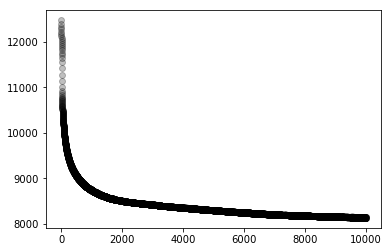

In [82]:
# Plot summed error as a function of iteration
plt.scatter(iterations, errors, c = "black", alpha = 0.25)

In [83]:
# Get rid of the 2nd dimension of 1 from the FloatTensor
y_pred_resized = y_pred.resize(11959)


# Make the FloatTensor into a numpy.array
y_pred_array = y_pred_resized.data.numpy()


# Make the numpy.array into a list
y_pred_list = y_pred_array.tolist()

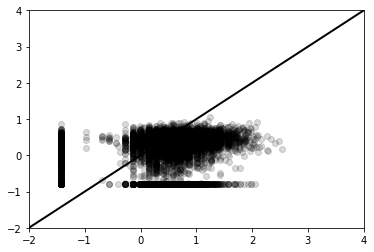

In [84]:
# Plot predictions versus training set outcomes
plt.scatter(outcomes_list, y_pred_list, c = "black", alpha = 0.15)

axes = plt.gca()

axes.set_xlim([-2, 4])

axes.set_ylim([-2, 4])

plt.plot([-2, 4], [-2, 4], 'k-', lw=2)

### Round 6.1: Validation Set Performance

In [85]:
# Get the validation set predictions
y_valid_pred = model(valid_predictors_Variable)


# Print the loss
loss_fn(y_valid_pred,
        valid_outcomes_Variable)

Variable containing:
 3285.4626
[torch.FloatTensor of size 1]

In [86]:
# Get rid of the 2nd dimension of 1 from the FloatTensor
y_valid_pred_resized = y_valid_pred.resize(3987)


# Make the FloatTensor into a numpy.array
y_valid_pred_array = y_valid_pred_resized.data.numpy()


# Convert back to log scale
y_valid_pred_array = y_valid_pred_array*5.407597 + 7.688844


# Make the numpy.array into a list
y_valid_pred_list = y_valid_pred_array.tolist()

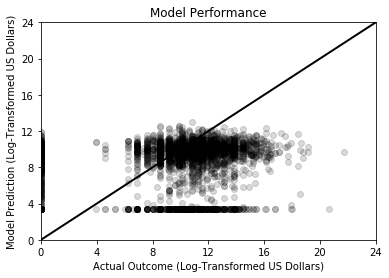

In [87]:
# Plot new predictions versus new data outcomes
plt.scatter(valid_outcomes_list, y_valid_pred_list, c = "black", alpha = 0.15)

axes = plt.gca()

axes.set_xlim([0, 24])

axes.set_ylim([0, 24])

axes.set_xticks([0, 4, 8, 12, 16, 20, 24])

axes.set_yticks([0, 4, 8, 12, 16, 20, 24])

plt.plot([0, 24], [0, 24], 'k-', lw = 2)

axes.set_xlabel("Actual Outcome (Log-Transformed US Dollars)")

axes.set_ylabel("Model Prediction (Log-Transformed US Dollars)")

axes.set_title("Model Performance")

In [88]:
model[(0)].weight

Parameter containing:

Columns 0 to 9 
 0.4321 -0.2373  0.0358  0.3635 -0.2109  0.3534 -0.3037  0.0780 -0.3094  0.1250
-0.4867 -0.0347  0.0466 -0.0456  0.2014 -0.3457  0.3105 -0.0150 -0.1337  0.0157
-0.1453  0.7616  0.0730  0.0488  0.1171  0.0605 -0.1808 -0.0709  0.5896  0.4231
 0.0544 -0.1168 -0.0607  0.1241  0.0800 -0.0646  0.0670  0.0835  0.4120  0.0215
-0.0010 -0.2104 -0.1256 -0.4167 -0.3157 -0.3191 -0.0961  0.3068 -0.2002 -0.0991
 0.0544  0.3458  0.1607 -0.1093  0.1464  0.0087 -0.1118 -0.2244 -0.3931  0.3237
-0.1257  0.1816 -0.2135 -0.0999  0.0391 -0.2642  0.1902  0.0855  0.1581  0.2798
-0.1878  0.4169 -0.0816  0.1790  0.0499 -0.0440 -0.2230 -0.1929  0.5552 -0.4058
 0.2088 -0.4298 -0.0427  0.1716  0.3402 -0.2470  0.0317 -0.0904 -0.3692 -0.1351
 0.4022 -0.2345 -0.3441 -0.3027  0.2026 -0.1966 -0.0971 -0.0343 -0.1908 -0.4981
 0.1441 -0.2618  0.1003  0.0326 -0.1032  0.0468  0.0014  0.0707 -0.1571 -0.1606
-0.1180 -0.1374  0.3625  0.2039 -0.2199 -0.1939 -0.2441  0.0662 -0.0356 -0.1808
 

In [89]:
model[(2)].weight

Parameter containing:

Columns 0 to 5 
 4.9618e-01  3.2096e-01 -1.1048e-01  1.6148e-01 -3.9550e-02  2.9816e-01
 2.6686e-01  5.9735e-02  8.0592e-02  2.3942e-01  1.7550e-01  2.0138e-01
 1.3181e-01  2.8988e-01  5.5693e-02  2.0802e-01 -2.2069e-01  4.4967e-01
-2.9852e-01  1.1871e-01 -1.2361e+00 -3.2336e-01  4.8689e-01 -3.4116e-01
 1.4156e-01 -1.1246e-01  6.2480e-01 -5.6506e-01  1.9788e-01  2.0789e-01
 7.1217e-01  2.1210e-01 -1.1521e-01  2.7576e-01  2.4200e-01  6.4876e-02
 1.9473e-01 -4.4155e-01 -1.1326e+00 -5.0567e-01  2.8850e-01 -4.4539e-01
 5.7585e-02 -2.6819e-01  5.9132e-01 -2.6835e-02  8.3787e-02 -6.6214e-01
 1.3648e-01 -9.8296e-02  3.0539e-01  4.7359e-01  5.8850e-02  2.2534e-01
 2.2706e-01 -8.3253e-02  1.2478e-02  7.7017e-02  2.8607e-01  3.4304e-01
 3.6091e-01  2.6947e-01  3.4721e-01 -1.2755e-01  2.8769e-01  3.2874e-01

Columns 6 to 11 
 2.4759e-01  3.3965e-01 -3.2216e-01  4.9932e-01 -3.1723e-01  1.4069e-01
 2.9553e-01  3.8952e-01 -3.9378e-01  3.5688e-01 -2.1513e-01  1.6508e-01
 1.0105

In [90]:
model[(4)].weight

Parameter containing:

Columns 0 to 9 
-0.5451 -0.4162 -0.2562  0.5785  0.2351  0.0426  0.5547  0.0930  0.2722 -0.3322
 0.3188 -0.1867  0.2129  0.0329 -0.3123  0.0706 -0.2975 -1.7637  0.3796 -0.4233
-0.2609 -0.0771 -0.3796  0.3653  0.4143 -0.1376  0.5397  0.1431 -0.2669 -0.0161
-0.2449 -0.5334 -0.2588  0.6203  0.5411 -0.0898  0.5572  0.1044 -0.1706  0.0163
 0.2311  0.2676  0.0538 -0.2634 -0.3555 -0.0079 -0.1695  0.4180 -0.0215  0.3673
 0.1424 -0.2650 -0.2220  0.1236 -0.2341 -0.2967 -0.0652 -0.0254  0.0053 -0.2973
 0.0441  0.2752  0.1759 -0.2941 -0.3170  0.5328 -0.2848  0.2707  0.2464  0.4402

Columns 10 to 10 
-0.0797
-0.6311
-0.2365
-0.3566
 0.3064
-0.1055
 0.0493
[torch.FloatTensor of size 7x11]

In [91]:
model[(6)].weight

Parameter containing:
 0.6350  2.1138  0.5452  0.8659  0.0241  0.1280  0.3321
-0.7844 -2.2546 -0.1854 -1.1406  0.1377  0.3717 -0.0191
-0.9262 -2.2051 -0.8033 -0.8471  0.0653 -0.0532  0.3774
-0.8144 -1.5570 -0.2034 -0.5872  0.3827  0.2349  0.0873
 0.4931  1.1572  0.8068  1.1070  0.1545  0.0687 -0.3139
[torch.FloatTensor of size 5x7]

In [92]:
model[(8)].weight

Parameter containing:
-0.8896  0.3376  0.4263  0.4731 -2.7930
-0.4737  0.3442  0.4835  0.1585 -1.2259
-0.6303  0.6215  0.5190  0.4432 -2.5442
[torch.FloatTensor of size 3x5]

In [93]:
model[(10)].weight

Parameter containing:
 0.2679  0.6759  0.4020
 0.7175  0.8398  0.6726
[torch.FloatTensor of size 2x3]

In [94]:
model[(12)].weight

Parameter containing:
 0.4433  0.8028
[torch.FloatTensor of size 1x2]

## Round 7: Linear Regression

In [95]:
# Make the torch Tensor into a PyTorch Variable for dependent variables
outcomes_Variable = Variable(outcomes_Tensor)


# ...for independent variables
features_Variable = Variable(features_Tensor,
                             requires_grad = False)

In [96]:
# Make the neural network - really a regression
model = torch.nn.Sequential(torch.nn.Linear(24, 1))

In [97]:
# To add errors to
errors = []


# Set the learning rate
learning_rate = 1e-2


# Define the model's optimizer
optimizer = torch.optim.Adagrad(model.parameters(), lr = learning_rate)


# Train the neural network
for t in range(10000):
    
    # Get the current predictions
    y_pred = model(features_Variable)
    
    # Compute and append current summed errors
    loss = loss_fn(y_pred, outcomes_Variable)
    errors.append(loss.data[0])
    
    # Zero the gradients before running the backward pass.
    optimizer.zero_grad()
    
    # Backward pass: compute gradient of the loss with respect to all the learnable Variables
    loss.backward()
    
    # Update the weights using Adagrad
    optimizer.step()

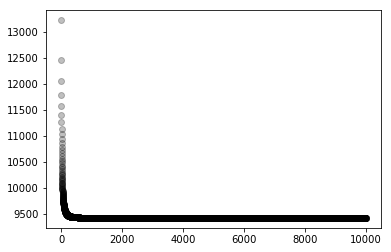

In [98]:
# Plot summed error as a function of iteration
plt.scatter(iterations, errors, c = "black", alpha = 0.25)

In [99]:
# Get rid of the 2nd dimension of 1 from the FloatTensor
y_pred_resized = y_pred.resize(11959)


# Make the FloatTensor into a numpy.array
y_pred_array = y_pred_resized.data.numpy()


# Make the numpy.array into a list
y_pred_list = y_pred_array.tolist()

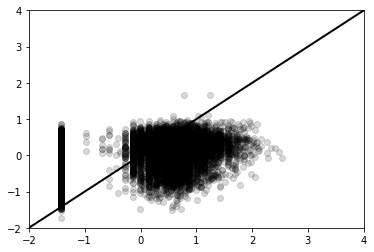

In [100]:
# Plot predictions versus training set outcomes
plt.scatter(outcomes_list, y_pred_list, c = "black", alpha = 0.15)

axes = plt.gca()

axes.set_xlim([-2, 4])

axes.set_ylim([-2, 4])

plt.plot([-2, 4], [-2, 4], 'k-', lw=2)

### Round 7.1: Validation Set Performance

In [101]:
# Get the validation set predictions
y_valid_pred = model(valid_predictors_Variable)


# Print the loss
loss_fn(y_valid_pred,
        valid_outcomes_Variable)

Variable containing:
 3193.2727
[torch.FloatTensor of size 1]

In [102]:
# Get rid of the 2nd dimension of 1 from the FloatTensor
y_valid_pred_resized = y_valid_pred.resize(3987)


# Make the FloatTensor into a numpy.array
y_valid_pred_array = y_valid_pred_resized.data.numpy()


# Convert back to log scale
y_valid_pred_array = y_valid_pred_array*5.407597 + 7.688844


# Make the numpy.array into a list
y_valid_pred_list = y_valid_pred_array.tolist()

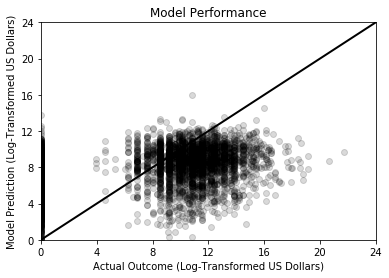

In [103]:
# Plot new predictions versus new data outcomes
plt.scatter(valid_outcomes_list, y_valid_pred_list, c = "black", alpha = 0.15)

axes = plt.gca()

axes.set_xlim([0, 24])

axes.set_ylim([0, 24])

axes.set_xticks([0, 4, 8, 12, 16, 20, 24])

axes.set_yticks([0, 4, 8, 12, 16, 20, 24])

plt.plot([0, 24], [0, 24], 'k-', lw = 2)

axes.set_xlabel("Actual Outcome (Log-Transformed US Dollars)")

axes.set_ylabel("Model Prediction (Log-Transformed US Dollars)")

axes.set_title("Model Performance")

In [104]:
model[(0)].weight

Parameter containing:

Columns 0 to 9 
-0.0071  0.1073 -0.0014 -0.0111  0.0015 -0.0726  0.0435 -0.0035  0.0944  0.0909

Columns 10 to 19 
-0.0042 -0.0201 -0.0583  0.0438  0.0158  0.0276  0.0027 -0.1834 -0.0440  0.1721

Columns 20 to 23 
 0.1238  0.0082  0.0454  0.0475
[torch.FloatTensor of size 1x24]